# Rt Live Model

In [1]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data_il, get_and_process_covidtracking_data_ilsev, summarize_inference_data

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-zro0rz5s because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Fetch data and select the state's data

In [2]:
df = get_and_process_covidtracking_data_il(run_date=pd.Timestamp.today())#-pd.Timedelta(days=1))
dfunn = get_and_process_covidtracking_data_il(run_date=pd.Timestamp.today(), norm=False)#-pd.Timedelta(days=1))
dfsev = get_and_process_covidtracking_data_ilsev(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

In [3]:
region = "Israel"
model_data = df.loc[region]
model_sev = dfsev.loc[region]
model_sev_dash = dfunn.loc[region]
model_sev_dash['positive'] = model_sev_dash['severe']
model_unn = dfunn.loc[region]

## Create the model instance and sample

In [4]:
gmsev = GenerativeModel(region, model_sev, buffer_days = 20, delay=2+5, sigma=0.07)
gmsev.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 4013 seconds.


In [5]:
gmsevdash = GenerativeModel(region, model_sev_dash, buffer_days = 20, delay=2+5, sigma=0.07)
gmsevdash.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 5119 seconds.


In [6]:
gmunn = GenerativeModel(region, model_unn, delay=2, sigma=0.07)
gmunn.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 3363 seconds.


## Summarize Model Output

In [7]:
resultsev = summarize_inference_data(gmsev.inference_data)
resultunn = summarize_inference_data(gmunn.inference_data)
resultsevdash = summarize_inference_data(gmsevdash.inference_data)

In [8]:
resultunn.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-12-19,1.294951,1.292170,1.138474,1.441655,4610.699697,3023.315312,1887.0,1887,100000
2020-12-20,1.286165,1.284824,1.132135,1.441068,4863.382162,3194.829741,3093.0,3093,100000
2020-12-21,1.275528,1.276961,1.120211,1.438868,5122.075019,3376.104032,3849.0,3849,100000
2020-12-22,1.263995,1.262334,1.086472,1.406744,5386.759235,3567.512894,4375.0,4375,100000
2020-12-23,1.253293,1.244784,1.095945,1.406047,5656.137099,3769.089778,4035.0,4035,100000
2020-12-24,1.232844,1.231862,1.068433,1.370141,5928.491441,3980.598042,4052.0,4052,100000
2020-12-25,1.209921,1.205974,1.040582,1.333883,6202.292191,4201.659820,4010.0,4010,100000
2020-12-26,1.189035,1.179949,1.041491,1.333104,6471.279078,4431.764006,2659.0,2659,100000
2020-12-27,1.163075,1.158816,1.010249,1.293661,6727.007733,4670.233368,3528.0,3528,100000


In [9]:
resultsev.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-12-18,1.202107,1.196988,1.069538,1.330897,100.088430,61.523999,59.0,59,10000
2020-12-19,1.193346,1.189299,1.055155,1.333080,103.923224,64.200145,59.0,59,10000
2020-12-20,1.185298,1.185869,1.040902,1.317617,107.782219,66.994081,62.0,62,10000
2020-12-21,1.173984,1.170360,1.028427,1.307265,111.636831,69.905987,69.0,69,10000
2020-12-22,1.160573,1.155000,0.994307,1.267079,115.455721,72.932540,83.0,83,10000
2020-12-23,1.144577,1.137151,0.996402,1.250560,119.198080,76.071085,78.0,78,10000
2020-12-24,1.129140,1.123793,0.985213,1.250011,122.797238,79.321315,77.0,77,10000
2020-12-25,1.112696,1.103531,0.960928,1.223662,126.181491,82.683664,84.0,84,10000
2020-12-26,1.088305,1.084425,0.953480,1.203435,129.293956,86.155275,74.0,74,10000


In [10]:
resultsevdash.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-12-19,1.192670,1.187936,1.072011,1.345293,120.122612,73.167993,72.0,72.0,100000
2020-12-20,1.178577,1.174440,1.035757,1.308782,124.551053,76.404884,69.0,69.0,100000
2020-12-21,1.166907,1.161672,1.028350,1.302410,128.972040,79.776787,77.0,77.0,100000
2020-12-22,1.156091,1.147492,0.999782,1.268361,133.302514,83.284488,90.0,90.0,100000
2020-12-23,1.139933,1.135561,0.987755,1.247411,137.469896,86.932189,86.0,86.0,100000
2020-12-24,1.125406,1.122466,0.976776,1.229005,141.478342,90.721274,89.0,89.0,100000
2020-12-25,1.105215,1.101063,0.987105,1.234649,145.260686,94.646695,106.0,106.0,100000
2020-12-26,1.091799,1.090595,0.971438,1.214758,148.737876,98.700124,89.0,89.0,100000
2020-12-27,1.076911,1.074816,0.950585,1.208856,151.817976,102.869494,99.0,99.0,100000


## Plot Model Output

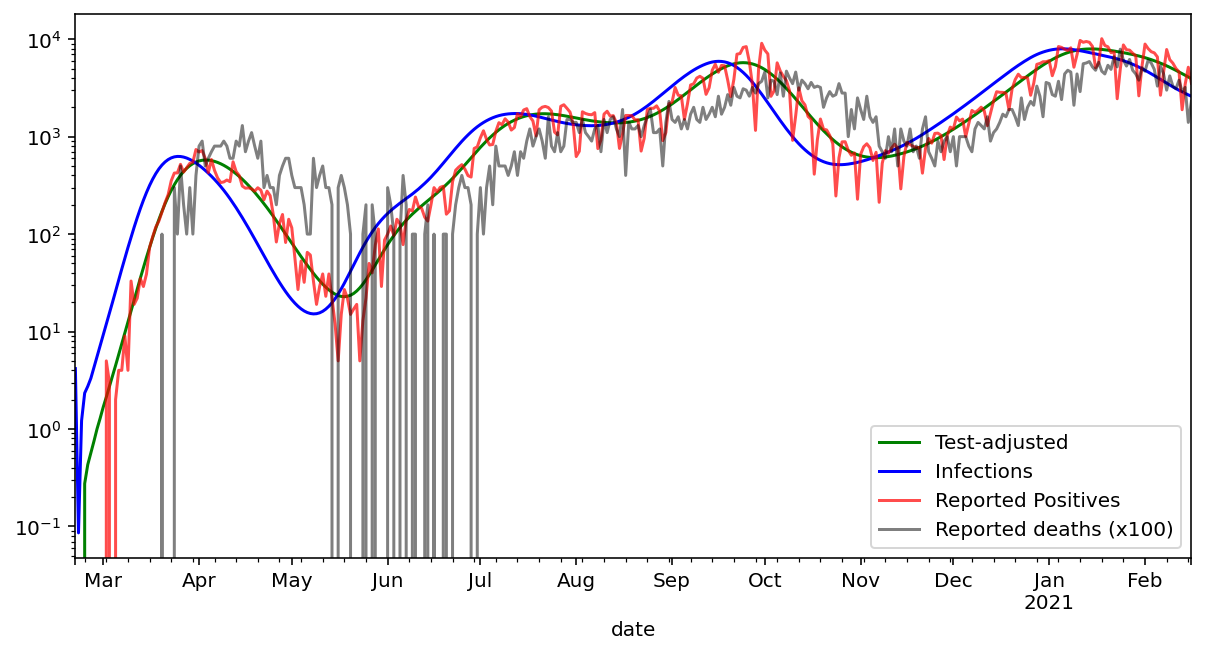

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
resultunn.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultunn.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultunn.infections.plot(c="b", label="Infections")
gmunn.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
d = gmunn.observed.deaths * 100
d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
plt.yscale("log")
fig.set_facecolor('w')
ax.legend();

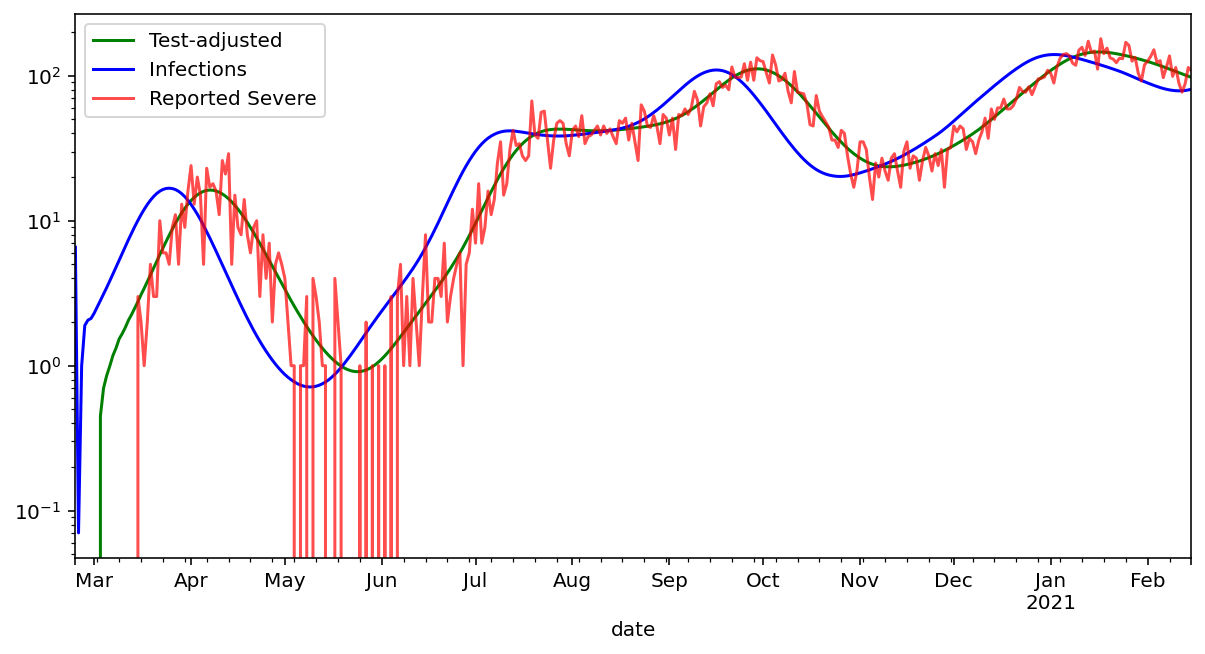

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
resultsev.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultsev.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultsev.infections.plot(c="b", label="Infections")
gmsev.observed.positive.plot(c='r', alpha=.7, label="Reported Severe")
fig.set_facecolor('w')
plt.yscale("log")
ax.legend();

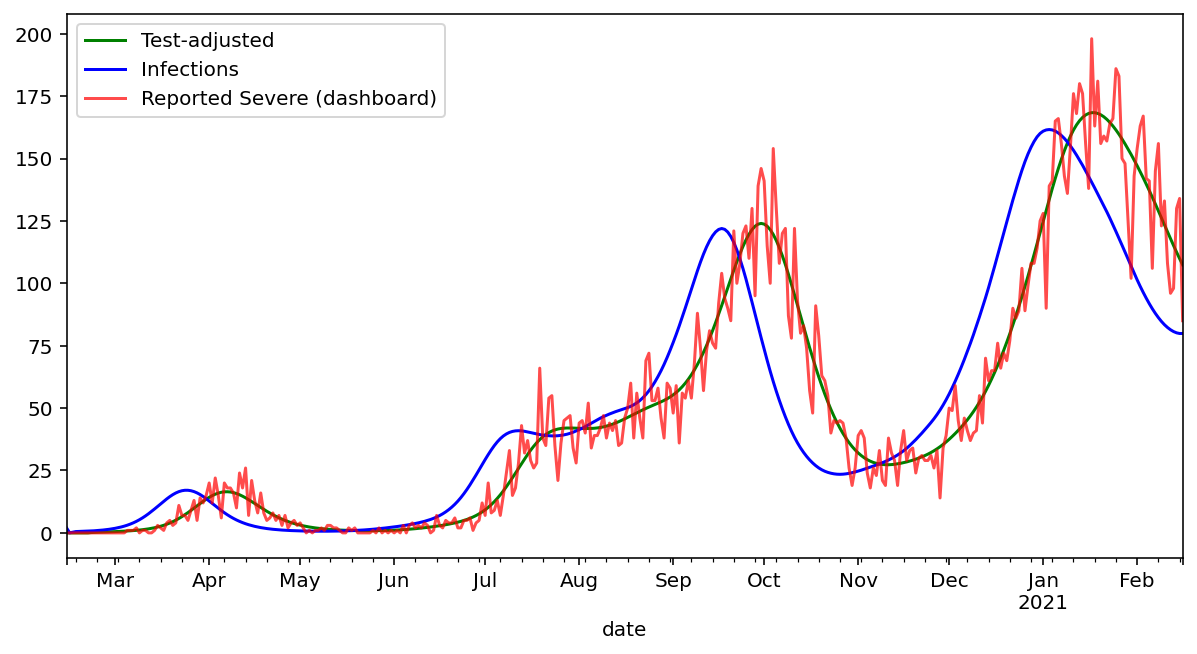

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
resultsevdash.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultsev.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultsevdash.infections.plot(c="b", label="Infections")
gmsevdash.observed.positive.plot(c='r', alpha=.7, label="Reported Severe (dashboard)")
fig.set_facecolor('w')
ax.legend();

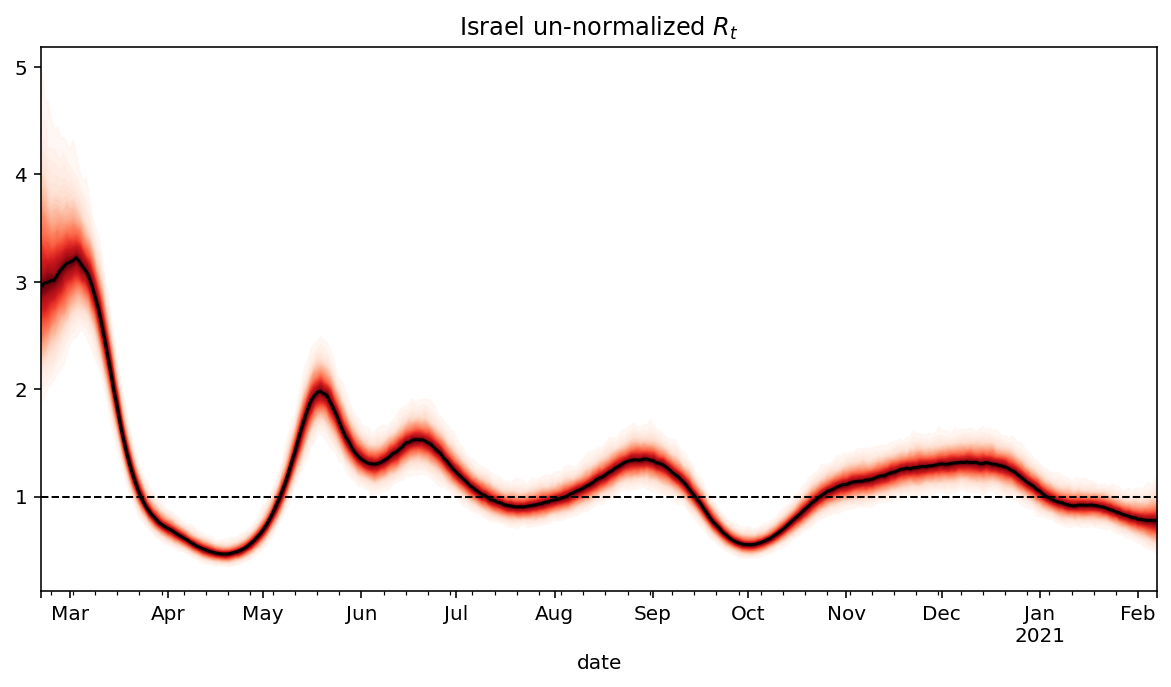

In [14]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} un-normalized $R_t$")
samples = gmunn.trace['r_t']
x=resultunn.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultunn["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_xlim(left = pd.Timestamp.today()-pd.Timedelta(days=70), right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_ylim(top = 2)
fig.set_facecolor('w')
fig.savefig("Israel_unnorm_Rt_est.svg")

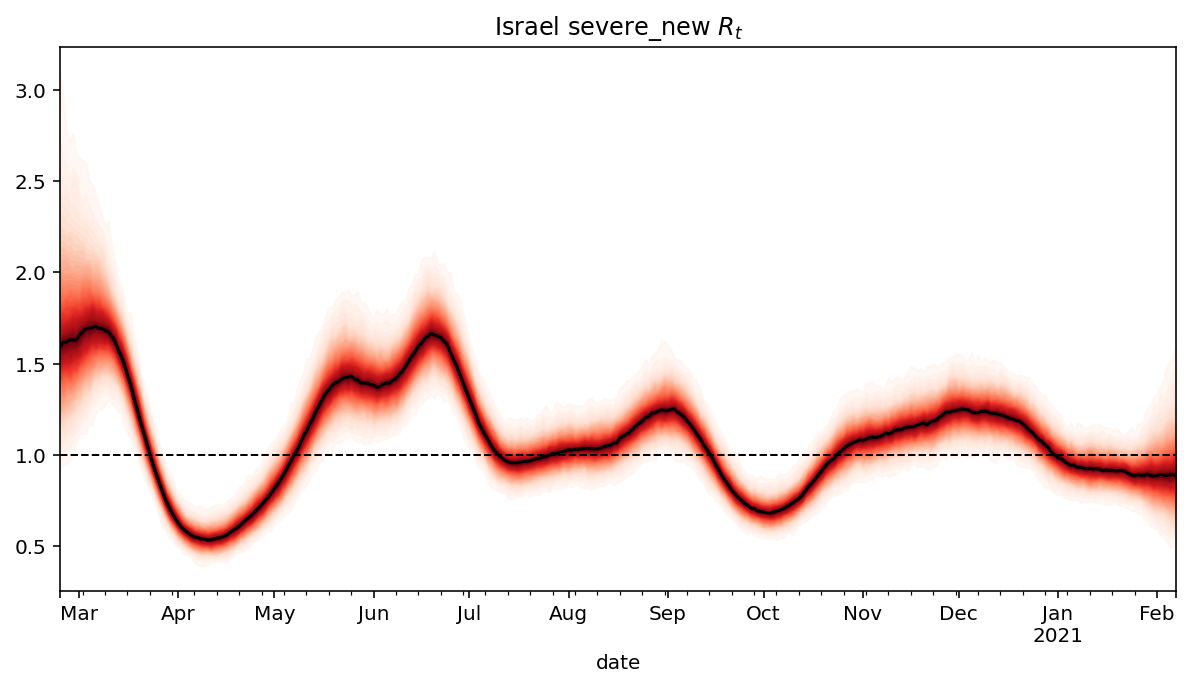

In [15]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} severe_new $R_t$")
samples = gmsev.trace['r_t']
x=resultsev.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultsev["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

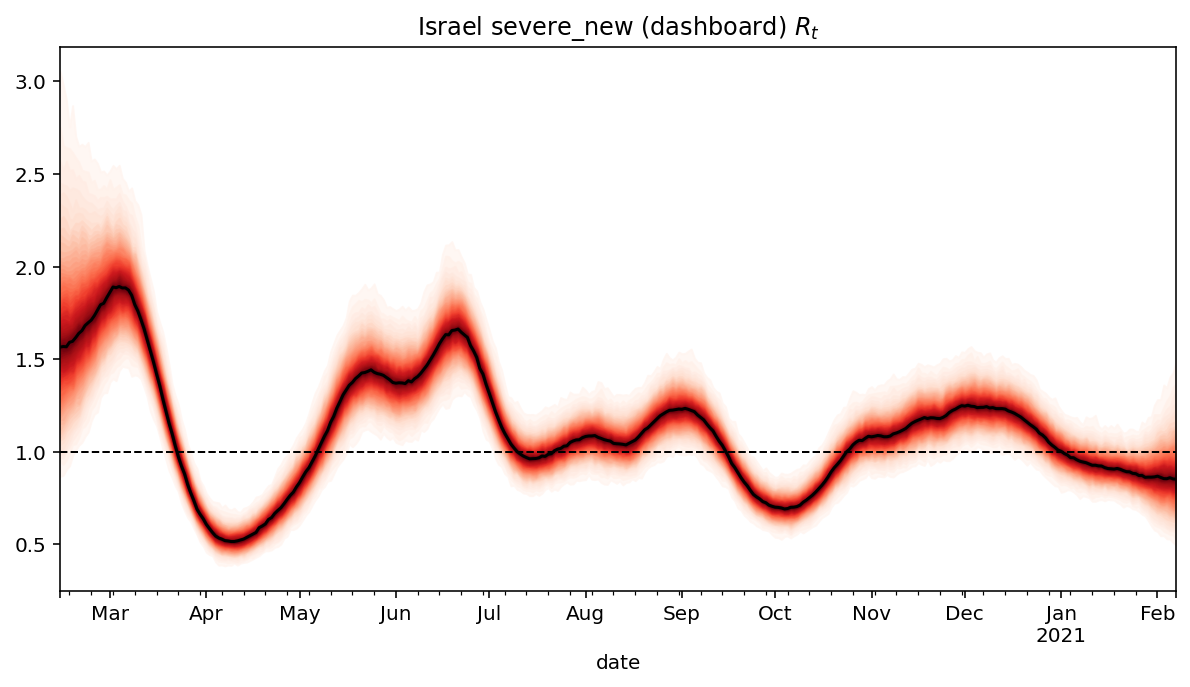

In [16]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} severe_new (dashboard) $R_t$")
samples = gmsevdash.trace['r_t']
x=resultsevdash.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultsevdash["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

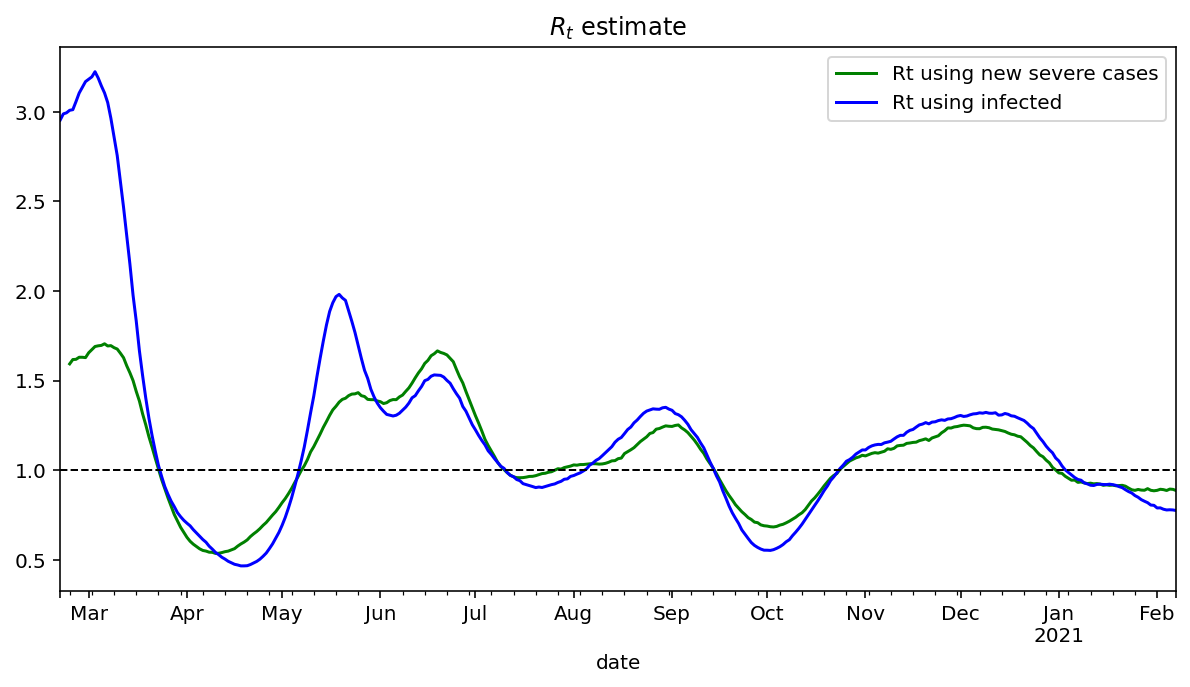

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f"$R_t$ estimate")
resultsev["median"].plot(c="g", ls='-', label="Rt using new severe cases")
#resultsevdash["median"].plot(c="r", ls='-', label="Rt using new severe cases from dashboard")
resultunn["median"].plot(c="b", ls='-', label="Rt using infected")
ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
ax.legend()

In [18]:
resultunn.to_csv("results_unnormalized_out.csv")

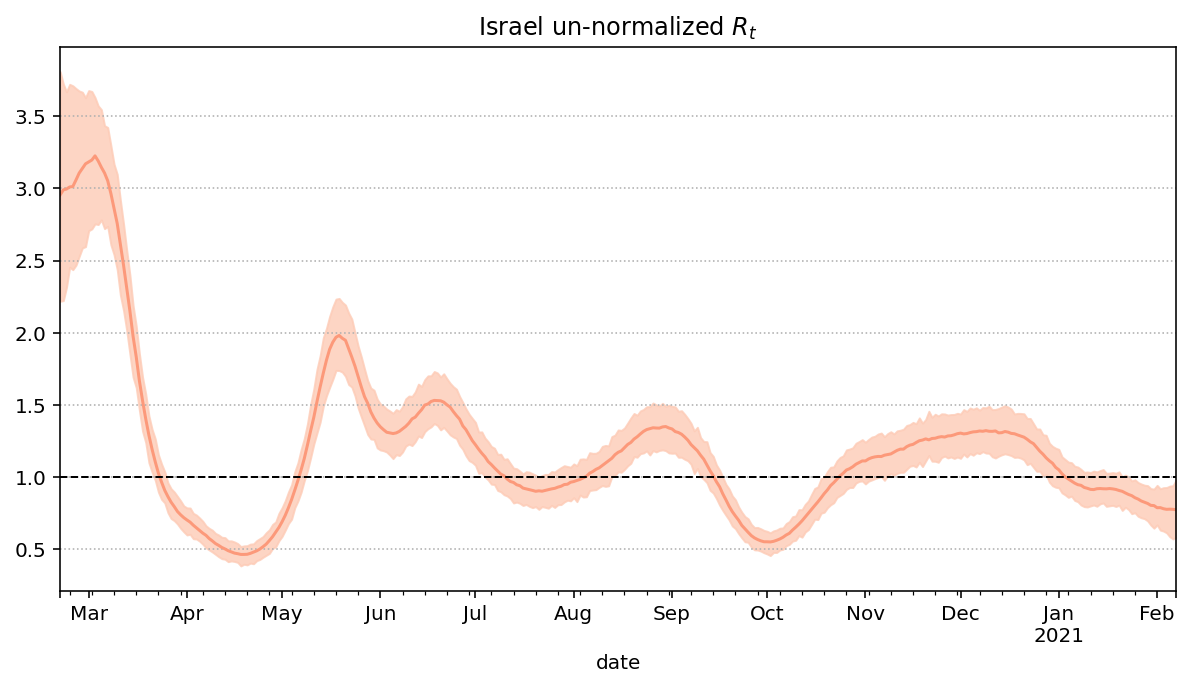

In [19]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} un-normalized $R_t$")
samples = gmunn.trace['r_t']
x=resultunn.index
cmap = plt.get_cmap("Reds")
ax.fill_between(x, resultunn["upper_80"], resultunn["lower_80"], color=cmap(50), alpha=.8)
resultunn["median"].plot(c=cmap(90), ls='-', label="Rt using infected")
ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_xlim(left = pd.Timestamp.today()-pd.Timedelta(days=70), right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_ylim(top = 2)
fig.set_facecolor('w')
plt.grid(which='major', axis='y', ls=':')
fig.savefig("Israel_unnorm_Rt_est.svg")